In [1]:
import pandas as pd
import uproot, dill, os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train=1e4
test=1e4
path = "../../data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file=uproot.open(path)
T = file['tree']

In [3]:
allstring=''
keys=[]
for key in T.keys():
    if 'mass' not in str(key)[2:-1] and 'massErr' not in str(key)[2:-1]:
        keys.append(str(key)[2:-1])
        allstring+=' '+str(key)[2:-1]
allstring=allstring[1:]
keys=keys[1:51]
no_true=[]
no_true_split=''
for key in keys:
    if 'true' not in key:
        no_true.append(key)
        no_true_split+=' '+key
no_true_split=no_true_split[1:]

In [4]:
features_johann=['cosTheta',
 'v0_ks_mass',
 'pT',
 'v0_rxyErr',
 'v0_rxy',
 'v0_chi2',
 'eventCounter',
 'ntrk_pv0',
 'a0',
 'a0xy',
 'v0_ks_massErr',
 'epsilon1',
 'calpha',
 'v0_ptErr',
 'pv0_y']

In [5]:
df = T.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" "), entrystop = train +test)
df_test=df.sample(frac=0.5)
df_train=df.loc[~df.index.isin(df_test.index)]
# df_test.describe(), df_train.describe()

In [6]:
#all fifty
df_all = T.pandas.df("npv ntrk_pv0 pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p v0_ptErr v0_px1 v0_py1 v0_pz1 v0_pt1 v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks rapidity_la rapidity_lb pseudorapidity".split(" "), entrystop=test+train)
df_all.head()

,npv,ntrk_pv0,pv0_x,pv0_y,pv0_z,a0xy,a0,a0z,cosTheta,v0_chi2,...,epsilon2,Alpha,pL1,pL2,pT,thetastar,rapidity_ks,rapidity_la,rapidity_lb,pseudorapidity
entry,,,,,,,,,,,,,,,,,,,,,
0,1,9,-0.639664,-0.625975,-12.355784,3.720766,6.466354,6.466354,-0.932089,7.692770,...,0.358493,-0.724833,256.042725,1604.953613,103.134270,2.598087,1.703833,0.856530,1.185391,2.049772
1,1,37,-0.668485,-0.670983,-9.130454,3.562052,4.220704,4.220704,0.842799,8.715455,...,0.271987,-0.606760,197.960434,808.855835,100.319809,2.430513,-1.431096,-0.607442,-0.767384,-2.010603
2,1,37,-0.668485,-0.670983,-9.130454,0.561421,1.488765,1.488765,-0.937126,2.268393,...,0.177384,-0.072050,720.137329,831.965942,127.857559,1.674291,-1.769233,-0.946002,-0.977256,-2.115104
3,1,37,-0.668485,-0.670983,-9.130454,1.540924,2.990223,2.990223,0.985514,0.618207,...,0.200212,-0.289240,706.308716,1281.166504,172.820572,1.931644,-1.891145,-1.055421,-1.201294,-2.325075
4,1,3,-0.711964,-0.495795,-2.192921,0.356632,0.363718,0.363718,-0.999696,0.038960,...,0.278782,0.091160,455.366425,379.280182,52.904900,1.332454,-1.530256,-0.627186,-0.605469,-2.049412


In [7]:
# define probability variable
model_path = "models/MC_trained_xgboost.dat"

func_seri = dill.load(open(model_path, 'rb'))
model = dill.loads(func_seri)

model_path = "models/MC_trained_xgboost_full.dat"

func_seri = dill.load(open(model_path, 'rb'))
predict_xgboost = dill.loads(func_seri)

(array([17081.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2919.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

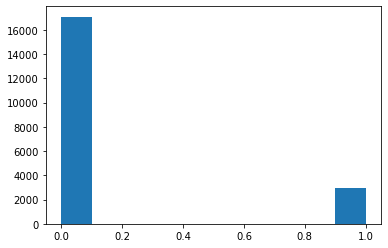

In [8]:
predict=predict_xgboost(df_all)
plt.hist(predict)

In [9]:
df_all['Predicted']=predict

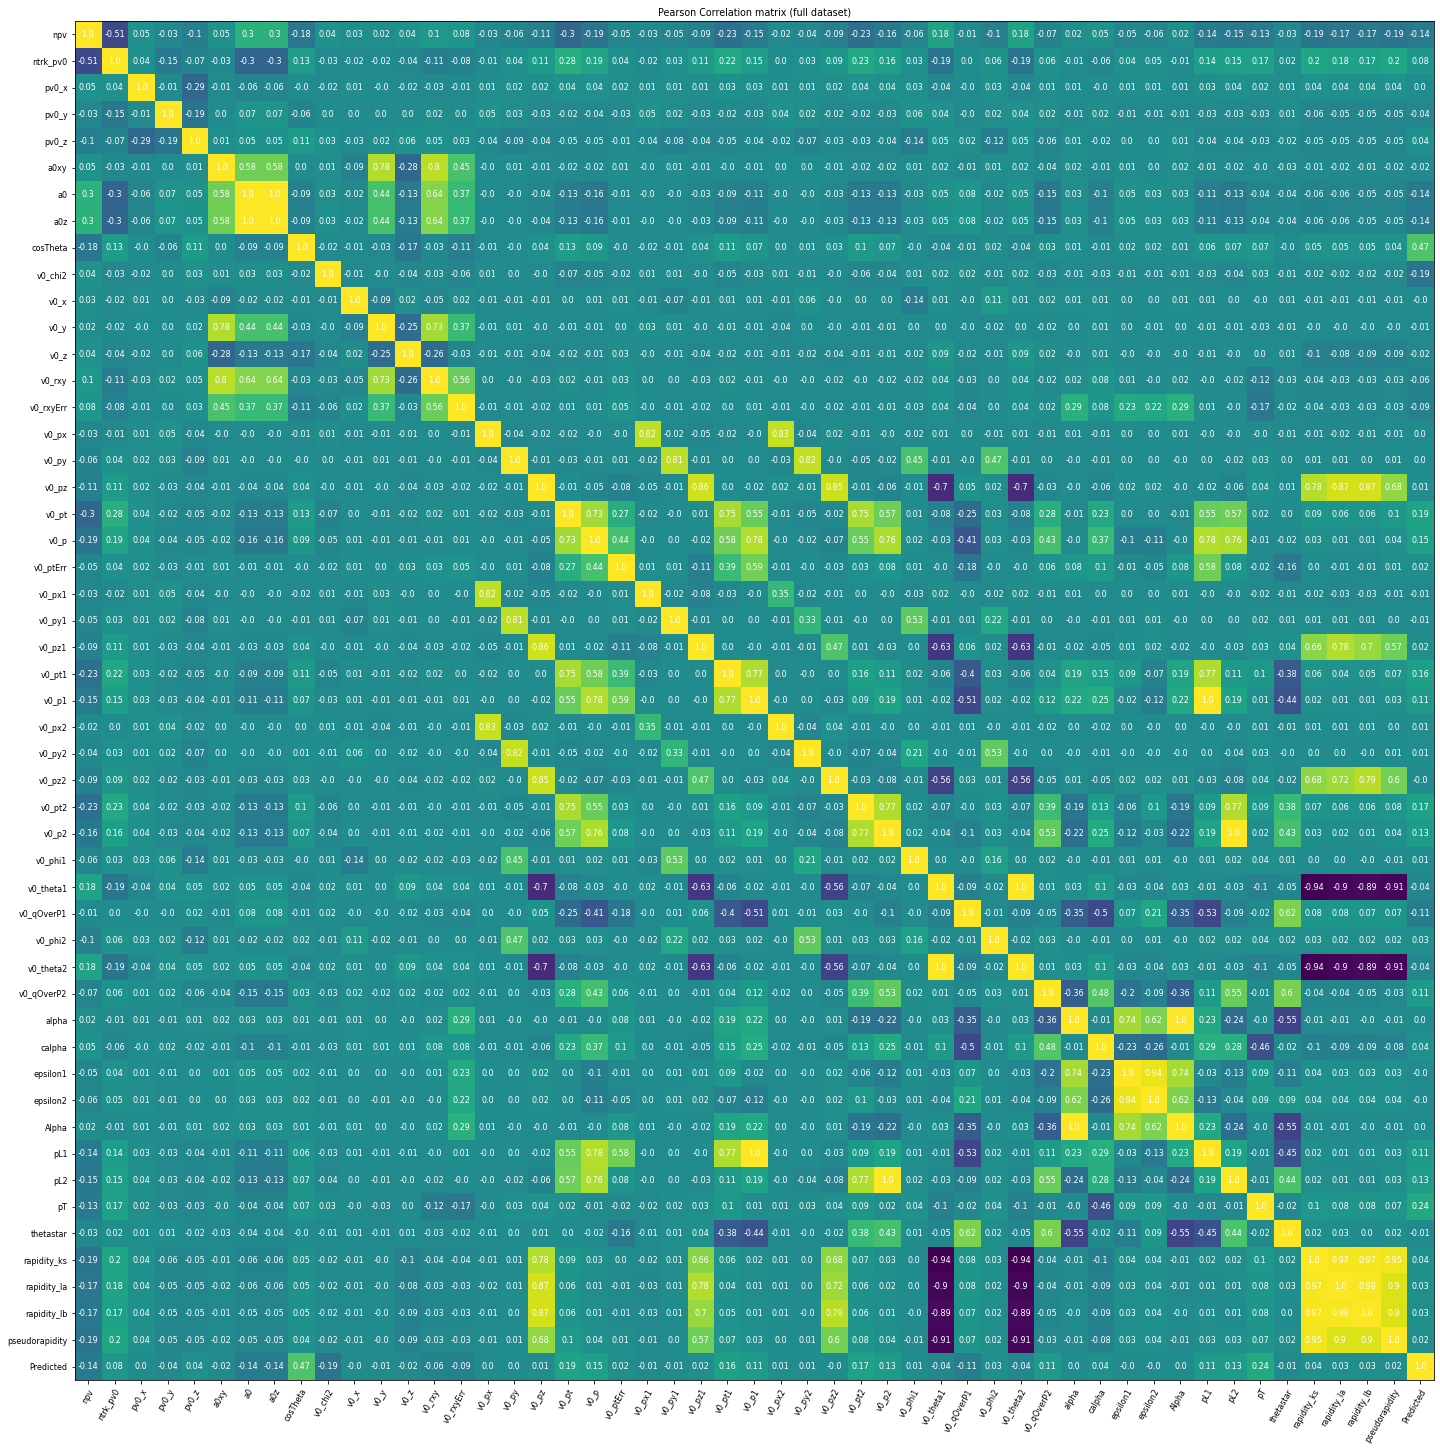

In [11]:
%matplotlib inline
from tqdm import tqdm
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(25,25))
corr=df_all.corr(method='pearson')
im = ax.imshow(corr)

# We want to show all ticks...
ax.set_xticks(np.arange(len(df_all.columns)))
ax.set_yticks(np.arange(len(df_all.columns)))
# ... and label them with the respective list entries
ax.set_xticklabels(df_all.columns)
ax.set_yticklabels(df_all.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(df_all.columns)):
    for j in range(len(df_all.columns)):
        text = ax.text(j, i, np.round(corr[df_all.columns[i]][df_all.columns[j]], 2),
                       ha="center", va="center", color="w")

ax.set_title("Pearson Correlation matrix (full dataset)")
# fig.tight_layout()
# plt.savefig('figs/Pearson Correlation.png')
plt.show()

In [25]:
import scipy.linalg as la
results = la.eig(corr)
decorr=results[1]

In [40]:
corr1=decorr.T@corr.to_numpy()@decorr

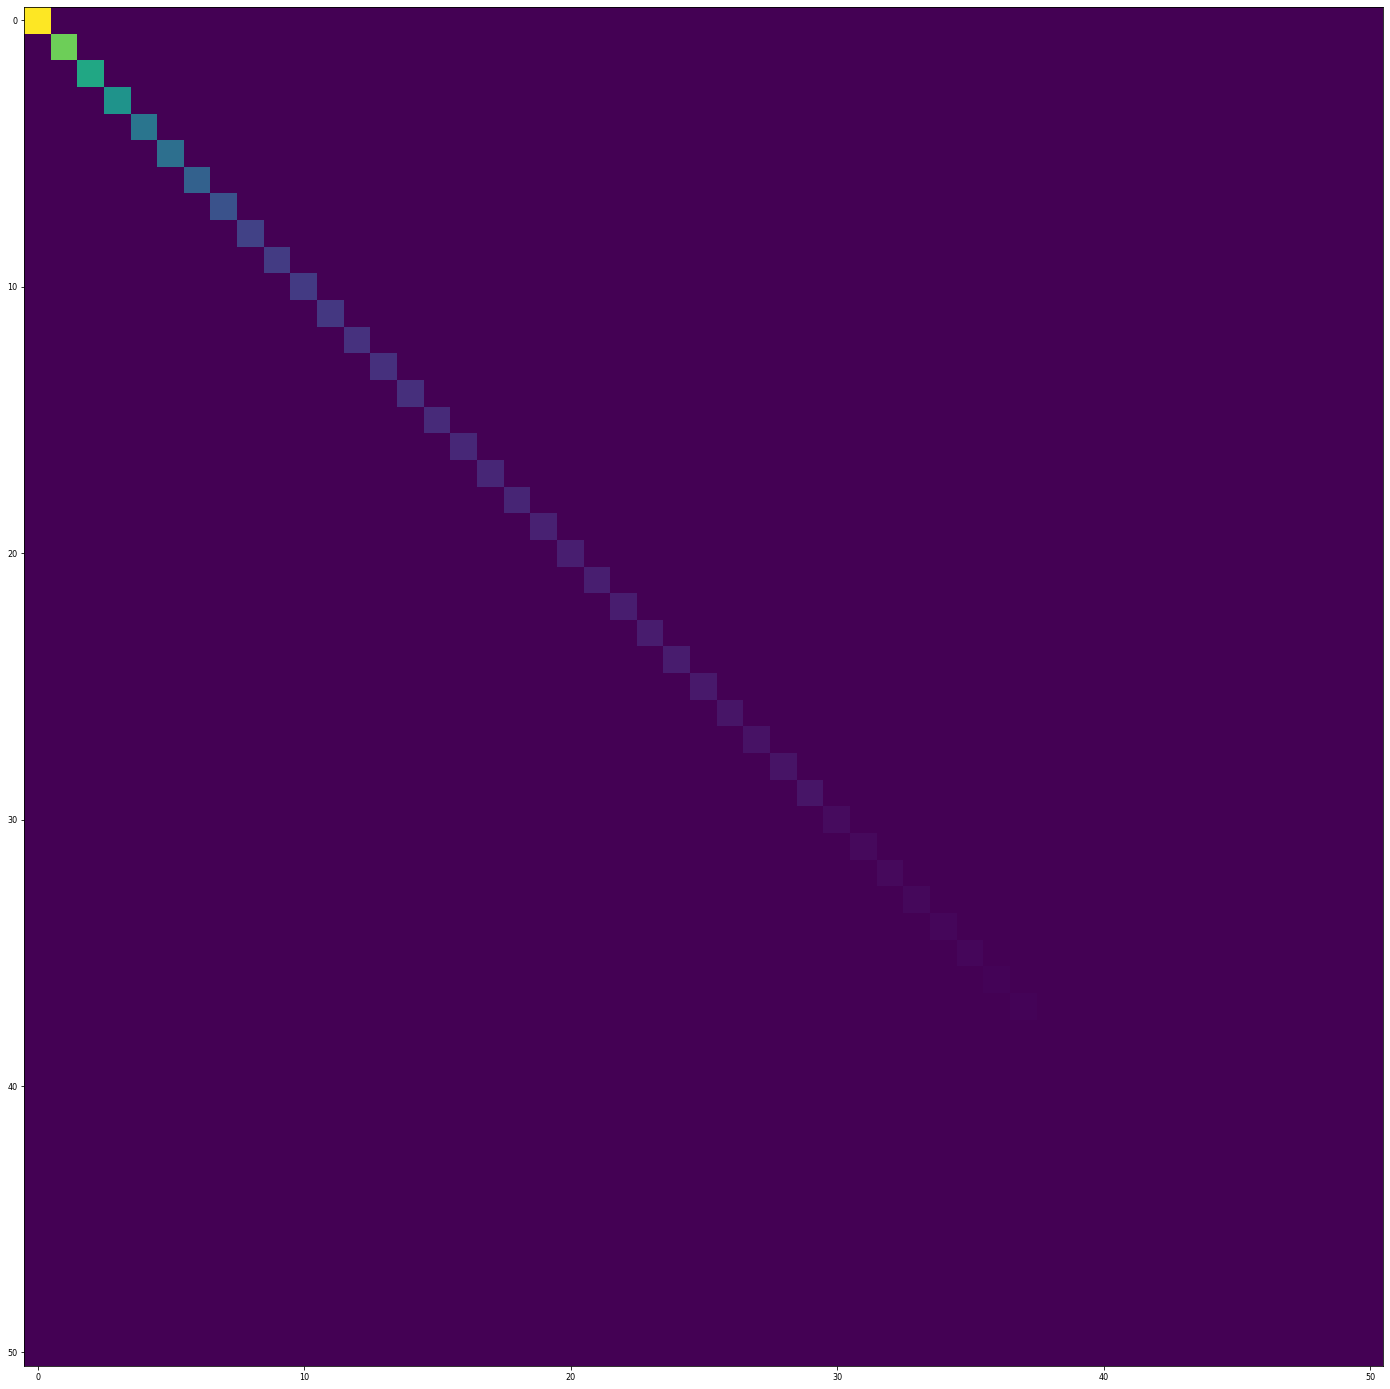

In [41]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(25,25))
im = ax.imshow(corr1)

In [47]:
for i in tqdm(range(len(decorr))):
    print(np.linalg.norm(decorr[i]))

100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 12783.69it/s]

0.9999999999999987
0.9999999999999972
1.0000000000000007
1.000000000000003
0.9999999999999989
0.9999999999999972
0.9493425061786627
0.9493425061747907
0.9999999999999982
0.9999999999999988
0.9999999999999971
0.9999999999999972
0.9999999999999992
1.0000000000000018
1.0000000000000004
0.9998711799000365
0.9993809146126956
1.10969798608957
1.000000000000002
1.0095000777680572
1.0000000000000024
0.9999533716670598
0.9997764102395656
1.0392108817100145
1.0000000000000053
1.0000000000000293
0.9999512371430637
0.9997598067448583
1.03820498832675
0.9999999999999981
0.9999999999999716
0.9999999999999982
0.9422582502203412
0.9999999999999979
0.9999999999999997
0.9422582501963261
0.999999999999998
1.0000000062217678
1.0
1.0000000000000004
0.9999999999999996
1.0000000062217393
1.0041293424640874
1.0038851507853768
0.9999999999999993
0.9999999999999919
0.9999999999999976
1.000000000000022
0.9999999999999833
1.0000000000000087
0.9999999999999969


In [ ]:
import minepy
from scipy.spatial.distance import squareform

In [ ]:
result=minepy.pstats(df_all)

In [ ]:
mat = squareform(result[0])
fig, ax = plt.subplots(figsize = (18, 16))
show = ax.imshow(mat) 
cols = df_all.columns

for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(j, i, np.round(mat[i, j], 2),
                       ha="center", va="center", color="w")

In [ ]:
def normalize_dataframe(dataframe, mc=False, truecol='trueKs'):
    """ Give truecol either as string or not, doesn't matter. Returns scaled dataframe w/o truelabel, truelabel series and 
    mean and standard deviation for each variable as a dictionary"""
    mustd={}
    if mc==True:
        label=dataframe[str(truecol)]
        dataframe=dataframe.drop(str(truecol), axis=1)
    df_all_norm = pd.DataFrame(None)
    for col in dataframe.columns[:57]:
        if dataframe[col].std() != 0:
            mustd[col]=(dataframe[col].mean(), dataframe[col].std())
            df_all_norm[col] = (dataframe[col] - dataframe[col].mean()) / dataframe[col].std()
    if mc==True:
        return df_all_norm, label, mustd
    else:
        return df_all_norm, mustd

In [ ]:
df_all_norm, mu_std=normalize_dataframe(df_all)